# Ant Colony Optimization

Volviendo a los 100 puntos|

In [8]:
#Importar librerias

import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from ortools.linear_solver import pywraplp
import time
import numpy as np

In [5]:
def create_2d_points_df(n, seed):
  """
  Genera n puntos en un espacio 2D y los guarda en un dataframe de pandas.

  Args:
    n: número de puntos
    seed: semilla aleatoria usada para por hacer reproducible el código

  Returns:
    Un dataframe de Pandas con las columnas "x", e "y".
  """
  points_data = []
  random.seed(seed)
  for i in range(n):
    x = random.uniform(-100, 100)
    y = random.uniform(-100, 100)
    points_data.append({'x': x, 'y': y})

  df = pd.DataFrame(points_data)
  return df


def calculate_distance(df):
  """
 Toma un dataframe con columnas 'x' e 'y' y calcula las distancias euclídeas

  Args:
    df: dataframe de pandas con columnas 'x' e 'y'.

  Returns:
    Una matriz de distancias euclídeas.
  """
  coords = df[['x', 'y']].values
  distance_matrix = cdist(coords, coords, metric='euclidean')
  return distance_matrix

def plot_points(df):
  """
  Plotea los puntos generados por create_2d_points_df.

  Args:
    df: df: dataframe de pandas con columnas 'x' e 'y'.
  """
  x_coords = df['x'].tolist()
  y_coords = df['y'].tolist()

  plt.figure(figsize=(8, 8))
  plt.scatter(x_coords, y_coords)
  plt.title('Puntos en el espacio 2D')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.grid(True)
  plt.show()


def points_sub(points, i):
    """
    De una lista de numeros sustrae el numero i en una copia nueva.
    Se considera que poinla lista no tiene elementos duplicados (por ser lista de indices) y que i se encuentra en la lista.

    Args:
      points: lista de puntos.
      i: elemento a sustraer de la lista

    Returns:
      new: lista nueva similar a points pero sin el elemento i.
    """
    new = points.copy()
    new.remove(i)
    return new

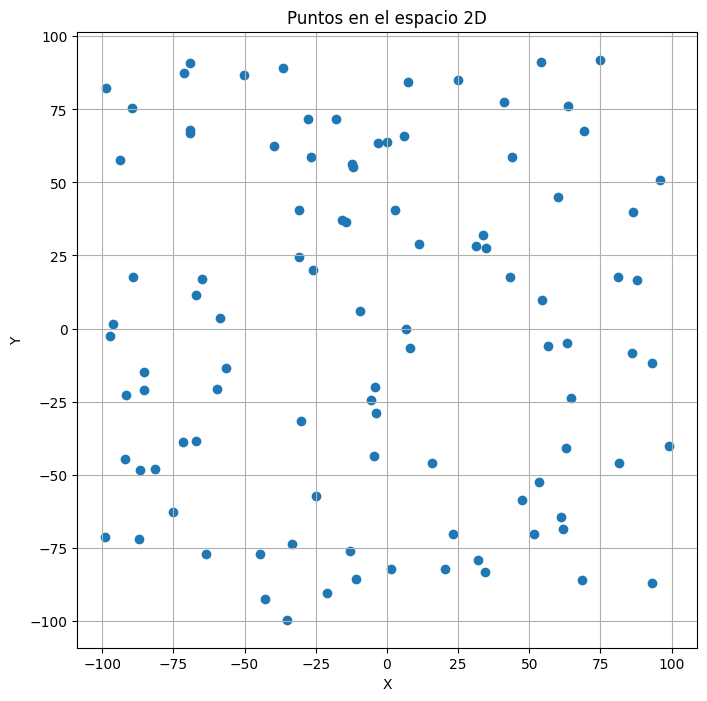

In [6]:
# Defino una semilla
seed = 1234

# Genero los puntos
puntos = create_2d_points_df(100, seed)

# Ploteo los puntos
plot_points(puntos)

# Calculo distancias
distancias = calculate_distance(puntos)

In [5]:
# Definimos el modelo
modelo_mtz = pywraplp.Solver.CreateSolver('SAT')

list_index_puntos = list(puntos.index)

# uso n como n-1 ya que arranco de indice 0 en la lista. Por esto en mtz no resto 1 ni en u_i
n = max(list_index_puntos)

# Definimos variables

x_ij={i:{j: modelo_mtz.IntVar(0,1,'x_'+str(i)+'_'+str(j)) for j in points_sub(list_index_puntos, i)} for i in list_index_puntos}
u_i = {i: modelo_mtz.IntVar(1,n,'u_'+str(i)) for i in points_sub(list_index_puntos, 0)}

# Definimos la función objetivo
obj_expr = sum(x_ij[i][j] * distancias[i][j] for i in list_index_puntos for j in points_sub(list_index_puntos, i))


#Restricciones:

#1
for j in list_index_puntos:
    modelo_mtz.Add(sum(x_ij[i][j] for i in points_sub(list_index_puntos, j)) == 1)

#2
for i in list_index_puntos:
    modelo_mtz.Add(sum(x_ij[i][j] for j in points_sub(list_index_puntos, i)) == 1)

#3
for i in points_sub(list_index_puntos, 0):
    for j in points_sub(points_sub(list_index_puntos, 0), i):
        modelo_mtz.Add(u_i[i] - u_i[j] + 1 <= n * (1- x_ij[i][j]))


# Solver
modelo_mtz.Minimize(obj_expr)

In [6]:
inicio = time.time()
status = modelo_mtz.Solve()
fin = time.time()
print("Tiempo de ejecución:", fin - inicio, "segundos")

Tiempo de ejecución: 697.2730700969696 segundos


In [7]:
if status == pywraplp.Solver.OPTIMAL:
    print("Costo total:", modelo_mtz.Objective().Value())
else:
    print("No se encontró solución óptima.")

Costo total: 1530.4892402519954


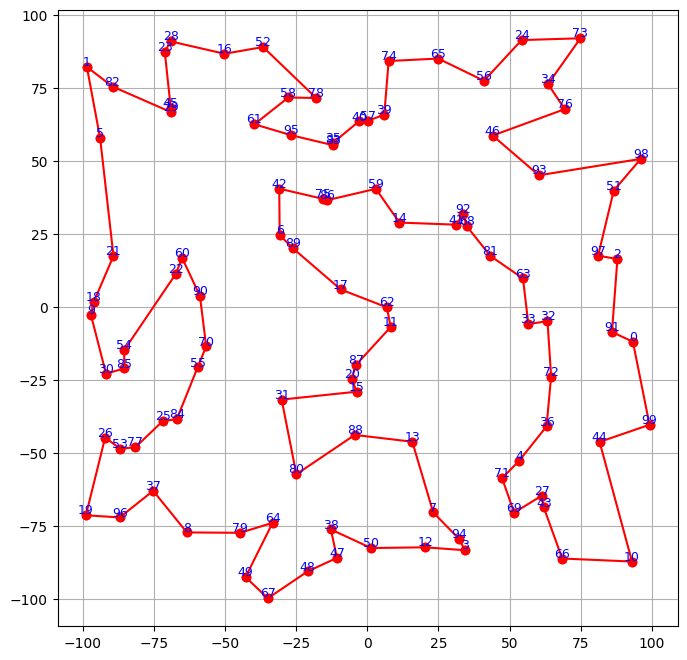

In [8]:
plt.figure(figsize=(8, 8))
plt.grid(True)
for i in list_index_puntos:
    for j in points_sub(list_index_puntos, i):
        if x_ij[i][j].SolutionValue() == 1:
            plt.plot(puntos.iloc[[i,j]]['x'], puntos.iloc[[i,j]]['y'], 'ro-')
            plt.text(puntos.iloc[i]['x'], puntos.iloc[i]['y'] + 0.5, str(i), ha='center', fontsize=9, color='blue')    
plt.show()

Esta ejecución llevó casi 12 minutos, con un costo mínimo encontrado de 1530.4892402519954

Y si usamos ACO?

In [ ]:
class AntColonyOptimizer:
    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        distances: Matriz de distancias (N x N)
        n_ants: Número de hormigas por iteración
        n_best: Cuántas de las mejores hormigas depositan feromona
        n_iterations: Número de veces que ejecutamos el ciclo
        decay: Tasa de evaporación de feromona (ej. 0.95)
        alpha: Importancia de la feromona (historia)
        beta: Importancia de la cercanía (heurística)

        Creado con asistencia de Copilot, revisado por José Keh
        """
        self.distances = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self, seed):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        np.random.seed(seed)
        random.seed(seed)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths(seed*(i+1))
            # Actualizamos la mejor ruta histórica si encontramos una nueva
            self.spread_pheronome(all_paths, self.n_best, shortest_path=all_time_shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
            
            # Evaporación de feromona (para no quedarse atascado en óptimos locales)
            self.pheromone = self.pheromone * self.decay

        return all_time_shortest_path

    def gen_all_paths(self, seed):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0, seed * (i+1)) # Todas las hormigas empiezan en la ciudad 0
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start_node, seed):
        path = [start_node]
        visited = set(path)
        prev = start_node
        
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited, seed*(i+1))
            path.append(move)
            visited.add(move)
            prev = move
        
        # Volver al inicio para cerrar el ciclo (TSP)
        path.append(start_node) 
        return path

    def pick_move(self, pheromone, dist, visited, seed):
        
        pheromone = np.copy(pheromone)
        # Hacemos 0 la feromona de las ciudades ya visitadas para no elegirlas
        pheromone[list(visited)] = 0

        # Heurística: 1 / distancia (si distancia es 0, poner un num muy grande)
        # Añadimos un pequeño epsilon para evitar división por cero si fuera el caso
        row_heuristic = 1.0 / (np.copy(dist) + 1e-10) 
        row_heuristic[list(visited)] = 0

        # Fórmula clave del ACO: (Feromona ^ alpha) * (Cercanía ^ beta)
        probability = (pheromone ** self.alpha) * (row_heuristic ** self.beta)

        # Normalizar para que la suma sea 1 (necesario para np.random.choice)
        norm_probability = probability / probability.sum()
        
        np.random.seed(seed)
        move = np.random.choice(self.all_inds, 1, p=norm_probability)[0]
        return move

    def gen_path_dist(self, path):
        total_dist = 0
        for i in range(len(path) - 1):
            total_dist += self.distances[path[i]][path[i+1]]
        return total_dist

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        # Ordenar caminos de mejor a peor
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        
        # Solo las mejores 'n_best' hormigas depositan feromona
        for path, dist in sorted_paths[:n_best]:
            for move in range(len(path) - 1):
                # A más corta la distancia, más feromona se deposita
                self.pheromone[path[move]][path[move+1]] += 1.0 / self.distances[path[move]][path[move+1]] # O lo hago /dist?


In [51]:
aco = AntColonyOptimizer(distances=distancias, 
                         n_ants=50,      # 5 hormigas por turno
                         n_best=20,      # Solo las 2 mejores dejan rastro fuerte
                         n_iterations=100, 
                         decay=0.95,    # La feromona se evapora un 5% cada vez
                         alpha=1, 
                         beta=2)        # Damos más peso a la cercanía (beta)

inicio = time.time()
mejor_camino, mejor_distancia = aco.run(42)
fin = time.time()
print("Tiempo de ejecución:", fin - inicio, "segundos")

print(f"Mejor ruta encontrada: {mejor_camino}")
print(f"Distancia total: {mejor_distancia}")

Tiempo de ejecución: 13.40118145942688 segundos
Mejor ruta encontrada: [0, np.int64(91), np.int64(32), np.int64(33), np.int64(63), np.int64(81), np.int64(68), np.int64(41), np.int64(92), np.int64(14), np.int64(59), np.int64(86), np.int64(75), np.int64(42), np.int64(6), np.int64(89), np.int64(17), np.int64(62), np.int64(11), np.int64(87), np.int64(20), np.int64(15), np.int64(88), np.int64(13), np.int64(7), np.int64(94), np.int64(3), np.int64(12), np.int64(50), np.int64(47), np.int64(38), np.int64(48), np.int64(67), np.int64(49), np.int64(79), np.int64(64), np.int64(80), np.int64(31), np.int64(70), np.int64(55), np.int64(84), np.int64(25), np.int64(77), np.int64(53), np.int64(26), np.int64(19), np.int64(96), np.int64(37), np.int64(8), np.int64(30), np.int64(85), np.int64(54), np.int64(9), np.int64(18), np.int64(21), np.int64(60), np.int64(22), np.int64(90), np.int64(5), np.int64(29), np.int64(45), np.int64(82), np.int64(1), np.int64(28), np.int64(23), np.int64(16), np.int64(52), np.int64

In [52]:
mejor_secuencia = mejor_camino[:-1]

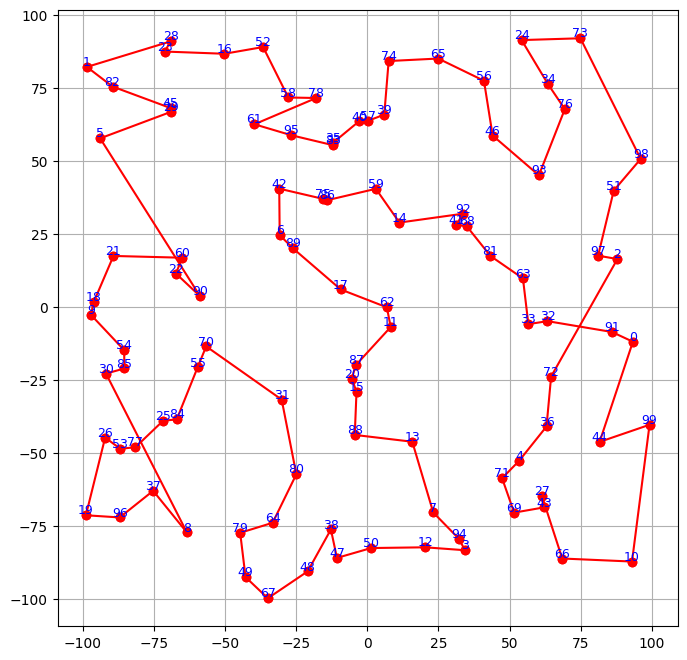

In [53]:
plt.figure(figsize=(8, 8))
plt.grid(True)
for i in range(len(mejor_secuencia)):
    j = (i + 1) % len(mejor_secuencia)
    plt.plot(puntos.iloc[[mejor_secuencia[i], mejor_secuencia[j]]]['x'], puntos.iloc[[mejor_secuencia[i], mejor_secuencia[j]]]['y'], 'ro-')
    plt.text(puntos.iloc[mejor_secuencia[i]]['x'], puntos.iloc[mejor_secuencia[i]]['y'] + 0.5, str(mejor_secuencia[i]), ha='center', fontsize=9, color='blue')